<a href="https://colab.research.google.com/github/dswh/lil_nlp_with_tensorflow/blob/main/03_02_begin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing LSTMs using TensorFlow

This notebook walks you through the implementation of an LSTM model to classify news headlines as sarcastic or not_sarcastic. We will analyse the accuracy & loss curves for training and validation sets.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

print(tf.__version__)

2.14.0


## Downloading the Headlines data


In [2]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/wdd-2-node.appspot.com/x1.json \
#     -o /tmp/headlines.json

In [3]:
import pandas as pd

data = pd.read_json("https://storage.googleapis.com/wdd-2-node.appspot.com/x1.json")
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

## Data Preparation

In [5]:
##define tokenizing and padding parameters
vocab_size = 31000
max_length = 40
embedding_dim = 25 # int(math.pow(2,math.log(vocab_size)))
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = int(len(headlines)*0.85)  # define training size(index)

In [6]:
##training set from 0 to training size
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

In [7]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

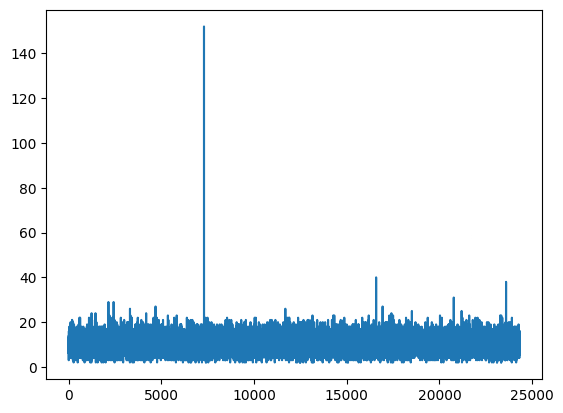

In [9]:
import matplotlib.pyplot as plt
plt.plot([len(i) for i in training_sequences])
plt.show()

## Define the LSTM model with the following layers:
1. Embedding layer
2. Add two bidirectional LSTM layers with 64 and 32 as number of outputs.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 25)            775000    
                                                                 
 bidirectional (Bidirection  (None, 40, 64)            14848     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 801033 (3.06 MB)
Trainable params: 801033 

In [12]:
num_epochs = 5
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    verbose=2)

Epoch 1/5
761/761 - 49s - loss: 0.3970 - accuracy: 0.8083 - val_loss: 0.3116 - val_accuracy: 0.8635 - 49s/epoch - 64ms/step
Epoch 2/5
761/761 - 39s - loss: 0.1655 - accuracy: 0.9371 - val_loss: 0.3281 - val_accuracy: 0.8609 - 39s/epoch - 51ms/step
Epoch 3/5
761/761 - 38s - loss: 0.0670 - accuracy: 0.9782 - val_loss: 0.4282 - val_accuracy: 0.8546 - 38s/epoch - 50ms/step
Epoch 4/5
761/761 - 37s - loss: 0.0319 - accuracy: 0.9903 - val_loss: 0.5513 - val_accuracy: 0.8563 - 37s/epoch - 49ms/step
Epoch 5/5
761/761 - 37s - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.5948 - val_accuracy: 0.8537 - 37s/epoch - 49ms/step


## Visualize accuracy and loss

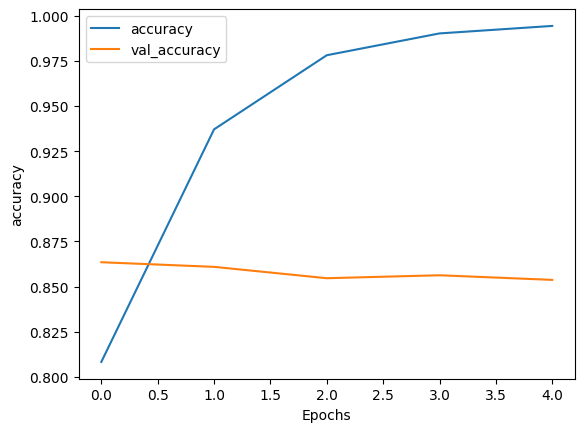

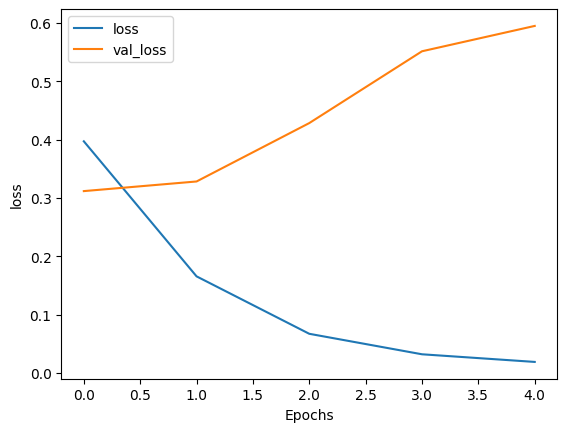

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

## Classifying unseen headlines

In [14]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 2s 2s/step
[[0.00091523]
 [0.00347787]]
